### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points. 

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either __pytorch__ or __tensorflow__ or any other framework (e.g. pure __keras__). Feel free to adapt the seminar code for your needs. For tensorflow version, consider `seminar_tf2.ipynb` as a starting point.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!wget https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip
data = pd.read_csv("./Train_rev1.zip", compression='zip', index_col=None)
data.shape

--2023-09-28 18:39:18--  https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip
Распознаётся ysda-seminars.s3.eu-central-1.amazonaws.com (ysda-seminars.s3.eu-central-1.amazonaws.com)… 52.219.169.110, 52.219.171.18, 3.5.134.169, ...
Подключение к ysda-seminars.s3.eu-central-1.amazonaws.com (ysda-seminars.s3.eu-central-1.amazonaws.com)|52.219.169.110|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 403 Forbidden
2023-09-28 18:39:21 ОШИБКА 403: Forbidden.



(244768, 12)

In [3]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

In [4]:
import nltk


tokenizer = nltk.tokenize.WordPunctTokenizer()

def tokenized(text: str) -> str:
    text = str(text)
    return " ".join(tokenizer.tokenize(text)).lower()


data["Title"] = data["Title"].apply(tokenized)
data["FullDescription"] = data["FullDescription"].apply(tokenized)

In [5]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in both "Title" and "FullDescription" in total

for title in data["Title"].values:
    token_counts.update(Counter(title.split()))

for description in data["FullDescription"].values:
    token_counts.update(Counter(description.split()))

In [6]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

token_to_id = {tokens[i]: i for i in range(len(tokens))}

In [7]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

# тут пришлось сделать длину токенов не меньше 5, так как одномерные свёртки не работали на меньшем количестве

def as_matrix(sequences, max_len=None, min_len=5):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    max_len = max(max_len, min_len)
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [8]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [9]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [10]:
import torch
import torch.nn as nn
import torch.functional as F


device = 'cuda' if torch.cuda.is_available() else 'cpu'


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [11]:
import gensim.downloader as api
glove_embedding = api.load('glove-twitter-100')

In [12]:
emb = nn.Embedding(len(tokens), 100)
emb.weight.requires_grad=False
new_emb = torch.zeros(len(tokens), 100)

for word, index in token_to_id.items():
    if word in glove_embedding:
        new_emb[index] = torch.tensor(glove_embedding.get_vector(word))
    else:
        new_emb[index] = emb.weight[index]

In [80]:
class TitleEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, n_tokens, embedding=None):
        super().__init__()
        
        if embedding == None:
            filter = 200
            self.emb = nn.Embedding(n_tokens, 200)
        else:     
            filter = 100
            self.emb = nn.Embedding.from_pretrained(embedding)
            self.emb.weight.requires_grad=True

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, bidirectional=True)
    
    def forward(self, idx):
        embs = self.emb(idx)
        out_lstm, (h_n, c_n) = self.lstm(embs)
        
        average_pool = torch.mean(out_lstm, dim=1)
        return average_pool


class CategorialEncoder(nn.Module):
    def __init__(self, n_cat_features):
        super().__init__()
        
        self.sequential = nn.Sequential(
            nn.Linear(n_cat_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        
    def forward(self, batch):
        out = self.sequential(batch)        
        return out


class SalaryPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, embedding=None, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super().__init__()
        self.title_enc = TitleEncoder(input_size, hidden_size, num_layers, n_tokens, embedding)
        self.descr_enc = TitleEncoder(input_size, hidden_size, num_layers, n_tokens, embedding)
        self.categorial_enc = CategorialEncoder(n_cat_features)

        self.title_enc.emb == self.descr_enc.emb
            
        self.sequential =  nn.Sequential(
            nn.Linear(160, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )
    
    def forward(self, batch):
        title_out = self.title_enc(batch['Title'])
        descr_out = self.descr_enc(batch['FullDescription'])
        cat_out = self.categorial_enc(batch['Categorical'])
        
        concat = torch.cat((title_out, descr_out, cat_out), 1)
        out = self.sequential(concat)
        
        return torch.transpose(out, 0, 1)[0]

In [81]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch
        
        if not cycle: break

In [82]:
from tqdm.auto import tqdm

BATCH_SIZE = 16
EPOCHS = 5


def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=torch.device('cpu'), **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae

In [83]:
BATCH_SIZE = 32
EPOCHS = 10

model = SalaryPredictor(input_size=200, hidden_size=32, num_layers=5).to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

loss_list = []
mse_list_val, mae_list_val = [], []

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    temp_loss = []
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        
        temp_loss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    mse_val, mae_val = print_metrics(model, data_val, device=device)
    print(f'loss: {round(np.mean(temp_loss), 4)}')
    
    mse_list_val.append(mse_val)
    mae_list_val.append(mae_val)
    
    loss_list.append(np.mean(temp_loss))

epoch: 0


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.13017
Mean absolute error: 0.27585
loss: 738.0692
epoch: 1


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.13229
Mean absolute error: 0.28211
loss: 4.2303
epoch: 2


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.15399
Mean absolute error: 0.31749
loss: 3.2166
epoch: 3


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.13067
Mean absolute error: 0.28788
loss: 2.8318
epoch: 4


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.09265
Mean absolute error: 0.23266
loss: 2.6333
epoch: 5


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.11256
Mean absolute error: 0.26366
loss: 2.4986
epoch: 6


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.12282
Mean absolute error: 0.28039
loss: 2.411
epoch: 7


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.14187
Mean absolute error: 0.30914
loss: 2.3254
epoch: 8


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.16263
Mean absolute error: 0.33567
loss: 2.2503
epoch: 9


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.10990
Mean absolute error: 0.26356
loss: 2.1918


### A short report

Please tell us what you did and how did it work.

# Первая модель со случайными эмбедингами и с предобученнымим 

Первая модель, не большая. C BatchNorm1d и MaxPooling. Я попробовал использовать случайные эмбединги и обучал их тоже. 

Батч 16, 10 эпох

Ниже виден средние mae и mse на обучении и средний loss в конце каждой эпохи

In [29]:
print(f"mse: {round(np.mean(mse_list_val), 4)}")
print(f"mae: {round(np.mean(mae_list_val),4)}")

mse: 0.1513
mae: 0.3088


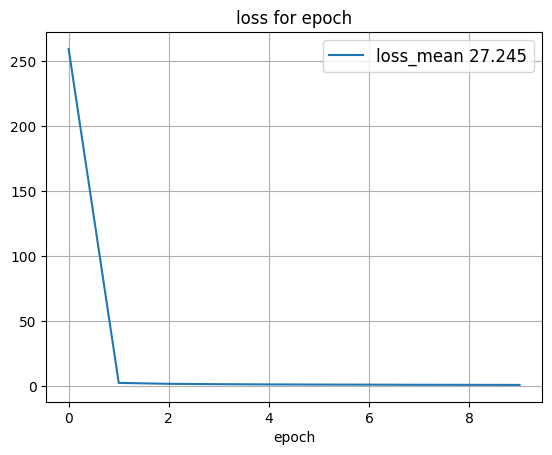

In [27]:
plt.title("loss for epoch")
plt.xlabel("epoch")
plt.plot(loss_list, label=f'loss_mean {round(np.mean(loss_list), 3)}')
plt.legend(fontsize='large')
plt.grid()

Тут та же модель, но с предобученными эмбедингами из glove_embedding = api.load('glove-twitter-100'). 

Батч 16, 10 эпох

Ниже виден средние mae и mse на обучении и средний loss в конце каждой эпохи.

Модель стала чуть лучше, но не сильно. loss немного меньше, mse тоже

In [31]:
print(f"mse: {round(np.mean(mse_list_val), 4)}")
print(f"mae: {round(np.mean(mae_list_val),4)}")

mse: 0.1463
mae: 0.3105


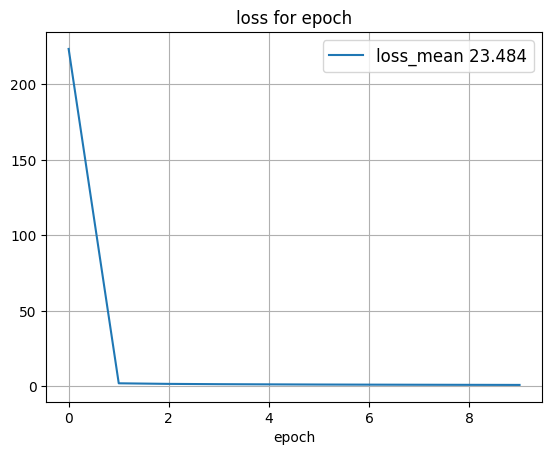

In [32]:
plt.title("loss for epoch")
plt.xlabel("epoch")
plt.plot(loss_list, label=f'loss_mean {round(np.mean(loss_list), 3)}')
plt.legend(fontsize='large')
plt.grid()

# Вторая модель с двумя головами

В модель TitleEncoder я добавил две головы, остальное оставил так же. Эмбединги случайны. Последовательность токенов в Title небольшая, поэтому много свёрток сделать не получится, а вот две головы возможно помогли бы. 

Батч 16, 10 эпох

Судя по mse и mae две головы не помогли

In [47]:
print(f"mse: {round(np.mean(mse_list_val), 4)}")
print(f"mae: {round(np.mean(mae_list_val),4)}")

mse: 0.209
mae: 0.377


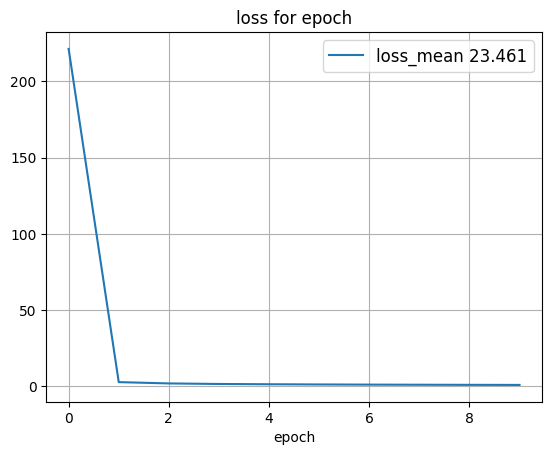

In [48]:
plt.title("loss for epoch")
plt.xlabel("epoch")
plt.plot(loss_list, label=f'loss_mean {round(np.mean(loss_list), 3)}')
plt.legend(fontsize='large')
plt.grid()

# Третья модель

Тут я для Title и для FullDescription сделал одну модель TitleEncoder, у которой две головы. Эмбединги случайные, длины 200.

Батч 32, 10 эпох. 

mse и mae стали меньше. Во время обучения mse падало до 0.09, а вот loss довольно высокий, возможно эту модель надо было ещё дообучить

In [43]:
print(f"mse: {round(np.mean(mse_list_val), 4)}")
print(f"mae: {round(np.mean(mae_list_val), 4)}")

mse: 0.1351
mae: 0.2858


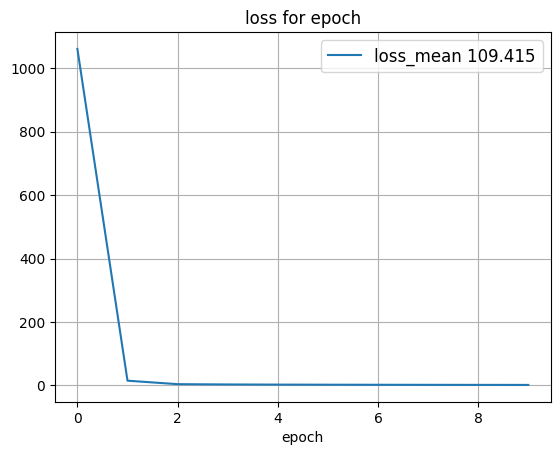

In [44]:
plt.title("loss for epoch")
plt.xlabel("epoch")
plt.plot(loss_list, label=f'loss_mean {round(np.mean(loss_list), 3)}')
plt.legend(fontsize='large')
plt.grid()

# Четвёртая модель

Тут я взял модели по проще со случайными эмбедингами. Убрал BatchNorm1d.Модель для Title и для FullDescription одинаковы. Эмбединги случайны, длины 200.

Батч 32, 10 эпох. ?

mse минимальное из всех, loss тоже. Кажется это лучшее что у меня получилось

In [32]:
print(f"mse: {round(np.mean(mse_list_val), 4)}")
print(f"mae: {round(np.mean(mae_list_val),4)}")

mse: 0.0702
mae: 0.1964


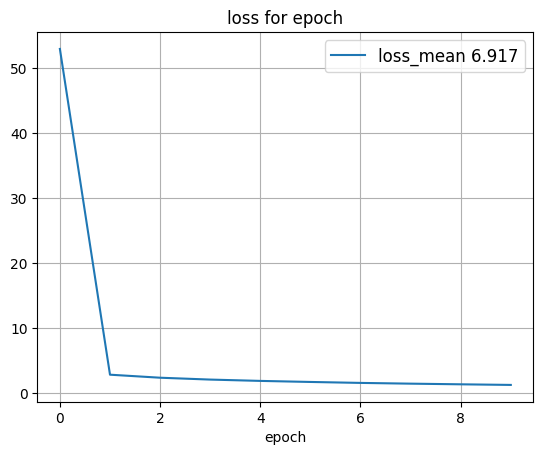

In [33]:
plt.title("loss for epoch")
plt.xlabel("epoch")
plt.plot(loss_list, label=f'loss_mean {round(np.mean(loss_list), 3)}')
plt.legend(fontsize='large')
plt.grid()

# Пятая модель

Тут я попробовал LSTM, довольно тупо и просто. Модель не большая. Модель на основе LSTM для Title и для FullDescription одинаковы. После LSTM стоит max_pooling Эмбединги случайны и тоже учатся.

Батч 32, 10 эпох. 

mse и mae довольно низки, на последних эпохах mse было 0.095. Возможно если ещё пообучать, то можно получить и меньше. 

In [77]:
print(f"mse: {round(np.mean(mse_list_val), 4)}")
print(f"mae: {round(np.mean(mae_list_val),4)}")

mse: 0.1155
mae: 0.2623


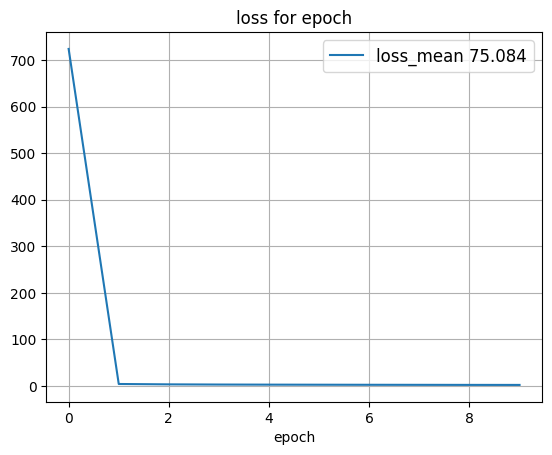

In [78]:
plt.title("loss for epoch")
plt.xlabel("epoch")
plt.plot(loss_list, label=f'loss_mean {round(np.mean(loss_list), 3)}')
plt.legend(fontsize='large')
plt.grid()

# Шестая модель

Тут я попробовал ту же модель что и пятая. Единственная разница это после LSTM стоит avg_pooling.

Батч 32, 10 эпох. 


С avg_pooling получилось хуже по метрикам 

In [84]:
print(f"mse: {round(np.mean(mse_list_val), 4)}")
print(f"mae: {round(np.mean(mae_list_val),4)}")

mse: 0.129
mae: 0.2848


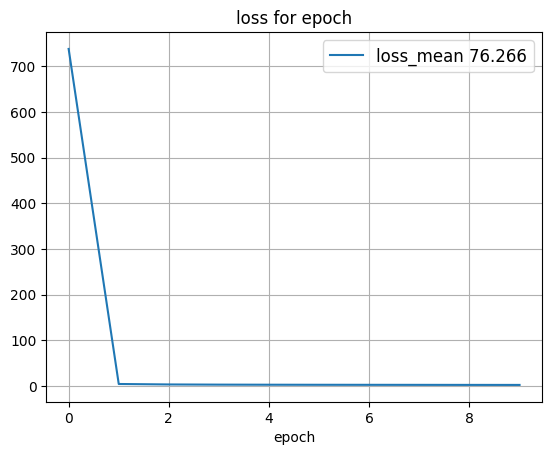

In [85]:
plt.title("loss for epoch")
plt.xlabel("epoch")
plt.plot(loss_list, label=f'loss_mean {round(np.mean(loss_list), 3)}')
plt.legend(fontsize='large')
plt.grid()

## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback(keras)](https://keras.io/callbacks/#earlystopping) or in [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!

# Модели, которые обучал

## Первая модель

In [22]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens, embedding=None):
        super().__init__()
        
        if embedding == None:
            self.emb = nn.Embedding(n_tokens, 100)
        else:     
            self.emb = nn.Embedding.from_pretrained(embedding)
            self.emb.weight.requires_grad=True
        
        self.sequential_1 =  nn.Sequential(
            nn.Conv1d(100, 64, kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(64, 32, kernel_size=3)
        )

    def forward(self, idx):
        embs = self.emb(idx).transpose(2, 1)
        
        out_1 = self.sequential_1(embs)
        max_pool = torch.max(out_1, dim=-1).values
        
        return max_pool


class FullDescriptionEncoder(nn.Module):
    def __init__(self, n_tokens, embedding=None):
        super().__init__()
        if embedding != None:
            self.emb = nn.Embedding.from_pretrained(embedding)
            self.emb.weight.requires_grad=True
        else:
            self.emb = nn.Embedding(n_tokens, 100)
            
        self.sequential =  nn.Sequential(
            nn.Conv1d(100, 64, kernel_size=3, stride=2),
            nn.MaxPool1d(kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv1d(64, 32, kernel_size=3)
        )
        
    def forward(self, idx):
        embs = self.emb(idx).transpose(2, 1)
        
        sequential_out = self.sequential(embs)        
        max_pool = torch.max(sequential_out, dim=-1).values
        
        return max_pool

class CategorialEncoder(nn.Module):
    def __init__(self, n_cat_features):
        super().__init__()
        
        self.sequential = nn.Sequential(
            nn.Linear(n_cat_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        
    def forward(self, batch):
        out = self.sequential(batch)        
        return out


class SalaryPredictor(nn.Module):
    def __init__(self, embedding=None, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super().__init__()
        self.title_enc = TitleEncoder(n_tokens, embedding)
        self.descr_enc = FullDescriptionEncoder(n_tokens, embedding)
        self.categorial_enc = CategorialEncoder(n_cat_features)

        self.title_enc.emb == self.descr_enc.emb
            
        self.sequential =  nn.Sequential(
            nn.Linear(96, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )
    
    def forward(self, batch):
        title_out = self.title_enc(batch['Title'])
        descr_out = self.descr_enc(batch['FullDescription'])
        cat_out = self.categorial_enc(batch['Categorical'])
        
        concat = torch.cat((title_out, descr_out, cat_out), 1)
        out = self.sequential(concat)
        
        return torch.transpose(out, 0, 1)[0]

# Вторая модель

In [23]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens, embedding=None):
        super().__init__()

        if embedding == None:
            self.emb = nn.Embedding(n_tokens, 100)
        else:     
            filter = 100
            self.emb = nn.Embedding.from_pretrained(embedding)
            self.emb.weight.requires_grad=True

        self.sequential_1 =  nn.Sequential(
            nn.Conv1d(filter, 64, kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(64, 32, kernel_size=3)
        )

        self.sequential_2 =  nn.Sequential(
            nn.Conv1d(filter, 64, kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(64, 32, kernel_size=3)
        )

    def forward(self, idx):
        embs = self.emb(idx).transpose(2, 1)
        
        out_1 = self.sequential_1(embs)
        out_2 = self.sequential_2(embs)

        concat = torch.cat((out_1, out_2), 1)
        max_pool = torch.max(concat, dim=-1).values
        
        return max_pool


class FullDescriptionEncoder(nn.Module):
    def __init__(self, n_tokens, embedding=None):
        super().__init__()
        if embedding != None:
            self.emb = nn.Embedding.from_pretrained(embedding)
            self.emb.weight.requires_grad=True
        else:
            self.emb = nn.Embedding(n_tokens, 100)
            
        self.sequential =  nn.Sequential(
            nn.Conv1d(filter, 64, kernel_size=3, stride=2),
            nn.MaxPool1d(kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv1d(64, 32, kernel_size=3)
        )
        
    def forward(self, idx):
        embs = self.emb(idx).transpose(2, 1)
        
        sequential_out = self.sequential(embs)        
        max_pool = torch.max(sequential_out, dim=-1).values
        
        return max_pool

class CategorialEncoder(nn.Module):
    def __init__(self, n_cat_features):
        super().__init__()
        
        self.sequential = nn.Sequential(
            nn.Linear(n_cat_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        
    def forward(self, batch):
        out = self.sequential(batch)        
        return out


class SalaryPredictor(nn.Module):
    def __init__(self, embedding=None, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super().__init__()
        self.title_enc = TitleEncoder(n_tokens, embedding)
        self.descr_enc = FullDescriptionEncoder(n_tokens, embedding)
        self.categorial_enc = CategorialEncoder(n_cat_features)

        self.title_enc.emb == self.descr_enc.emb
            
        self.sequential =  nn.Sequential(
            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )
    
    def forward(self, batch):
        title_out = self.title_enc(batch['Title'])
        descr_out = self.descr_enc(batch['FullDescription'])
        cat_out = self.categorial_enc(batch['Categorical'])
        
        concat = torch.cat((title_out, descr_out, cat_out), 1)
        out = self.sequential(concat)
        
        return torch.transpose(out, 0, 1)[0]

# Третья модель

In [24]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens, embedding=None):
        super().__init__()
        
        if embedding == None:
            filter = 200
            self.emb = nn.Embedding(n_tokens, 200)
        else:     
            filter = 100
            self.emb = nn.Embedding.from_pretrained(embedding)
            self.emb.weight.requires_grad=True
        
        self.sequential_1 =  nn.Sequential(
            nn.Conv1d(filter, 64, kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(64, 32, kernel_size=3)
        )

        self.sequential_2 =  nn.Sequential(
            nn.Conv1d(filter, 64, kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(64, 32, kernel_size=3)
        )

    def forward(self, idx):
        embs = self.emb(idx).transpose(2, 1)
        
        out_1 = self.sequential_1(embs)
        out_2 = self.sequential_2(embs)

        concat = torch.cat((out_1, out_2), 1)
        max_pool = torch.max(concat, dim=-1).values
        
        return max_pool
        

class CategorialEncoder(nn.Module):
    def __init__(self, n_cat_features):
        super().__init__()
        
        self.sequential = nn.Sequential(
            nn.Linear(n_cat_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        
    def forward(self, batch):
        out = self.sequential(batch)        
        return out


class SalaryPredictor(nn.Module):
    def __init__(self, embedding=None, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super().__init__()
        self.title_enc = TitleEncoder(n_tokens, embedding)
        self.descr_enc = TitleEncoder(n_tokens, embedding)
        self.categorial_enc = CategorialEncoder(n_cat_features)

        self.title_enc.emb == self.descr_enc.emb
            
        self.sequential =  nn.Sequential(
            nn.Linear(160, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )
    
    def forward(self, batch):
        title_out = self.title_enc(batch['Title'])
        descr_out = self.descr_enc(batch['FullDescription'])
        cat_out = self.categorial_enc(batch['Categorical'])
        
        concat = torch.cat((title_out, descr_out, cat_out), 1)
        out = self.sequential(concat)
        
        return torch.transpose(out, 0, 1)[0]

# Четвёртая модель

In [ ]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens, embedding=None):
        super().__init__()
        
        if embedding == None:
            filter = 200
            self.emb = nn.Embedding(n_tokens, 200)
        else:     
            filter = 100
            self.emb = nn.Embedding.from_pretrained(embedding)
            self.emb.weight.requires_grad=True
       
        self.sequential_1 =  nn.Sequential(
            nn.Conv1d(filter, 64, kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(64, 32, kernel_size=3)
        )

    def forward(self, idx):
        embs = self.emb(idx).transpose(2, 1)
        
        out_1 = self.sequential_1(embs)
        max_pool = torch.max(out_1, dim=-1).values
        
        return max_pool


class CategorialEncoder(nn.Module):
    def __init__(self, n_cat_features):
        super().__init__()
        
        self.sequential = nn.Sequential(
            nn.Linear(n_cat_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        
    def forward(self, batch):
        out = self.sequential(batch)        
        return out


class SalaryPredictor(nn.Module):
    def __init__(self, embedding=None, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super().__init__()
        self.title_enc = TitleEncoder(n_tokens, embedding)
        self.descr_enc = TitleEncoder(n_tokens, embedding)
        self.categorial_enc = CategorialEncoder(n_cat_features)

        self.title_enc.emb == self.descr_enc.emb
            
        self.sequential =  nn.Sequential(
            nn.Linear(96, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )
    
    def forward(self, batch):
        title_out = self.title_enc(batch['Title'])
        descr_out = self.descr_enc(batch['FullDescription'])
        cat_out = self.categorial_enc(batch['Categorical'])
        
        concat = torch.cat((title_out, descr_out, cat_out), 1)
        out = self.sequential(concat)
        
        return torch.transpose(out, 0, 1)[0]

# Пятая модель

In [ ]:
class TitleEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, n_tokens, embedding=None):
        super().__init__()
        
        if embedding == None:
            filter = 200
            self.emb = nn.Embedding(n_tokens, 200)
        else:     
            filter = 100
            self.emb = nn.Embedding.from_pretrained(embedding)
            self.emb.weight.requires_grad=True

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, bidirectional=True)
    
    def forward(self, idx):
        embs = self.emb(idx)
        out_lstm, (h_n, c_n) = self.lstm(embs)
        
        max_pool = torch.max(out_lstm, dim=1).values
        return max_pool


class CategorialEncoder(nn.Module):
    def __init__(self, n_cat_features):
        super().__init__()
        
        self.sequential = nn.Sequential(
            nn.Linear(n_cat_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        
    def forward(self, batch):
        out = self.sequential(batch)        
        return out


class SalaryPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, embedding=None, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super().__init__()
        self.title_enc = TitleEncoder(input_size, hidden_size, num_layers, n_tokens, embedding)
        self.descr_enc = TitleEncoder(input_size, hidden_size, num_layers, n_tokens, embedding)
        self.categorial_enc = CategorialEncoder(n_cat_features)

        self.title_enc.emb == self.descr_enc.emb
            
        self.sequential =  nn.Sequential(
            nn.Linear(160, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )
    
    def forward(self, batch):
        title_out = self.title_enc(batch['Title'])
        descr_out = self.descr_enc(batch['FullDescription'])
        cat_out = self.categorial_enc(batch['Categorical'])
        
        concat = torch.cat((title_out, descr_out, cat_out), 1)
        out = self.sequential(concat)
        
        return torch.transpose(out, 0, 1)[0]

# Шестая модель

In [ ]:
class TitleEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, n_tokens, embedding=None):
        super().__init__()
        
        if embedding == None:
            filter = 200
            self.emb = nn.Embedding(n_tokens, 200)
        else:     
            filter = 100
            self.emb = nn.Embedding.from_pretrained(embedding)
            self.emb.weight.requires_grad=True

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, bidirectional=True)
    
    def forward(self, idx):
        embs = self.emb(idx)
        out_lstm, (h_n, c_n) = self.lstm(embs)
        
        average_pool = torch.mean(out_lstm, dim=1)
        return average_pool


class CategorialEncoder(nn.Module):
    def __init__(self, n_cat_features):
        super().__init__()
        
        self.sequential = nn.Sequential(
            nn.Linear(n_cat_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        
    def forward(self, batch):
        out = self.sequential(batch)        
        return out


class SalaryPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, embedding=None, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super().__init__()
        self.title_enc = TitleEncoder(input_size, hidden_size, num_layers, n_tokens, embedding)
        self.descr_enc = TitleEncoder(input_size, hidden_size, num_layers, n_tokens, embedding)
        self.categorial_enc = CategorialEncoder(n_cat_features)

        self.title_enc.emb == self.descr_enc.emb
            
        self.sequential =  nn.Sequential(
            nn.Linear(160, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )
    
    def forward(self, batch):
        title_out = self.title_enc(batch['Title'])
        descr_out = self.descr_enc(batch['FullDescription'])
        cat_out = self.categorial_enc(batch['Categorical'])
        
        concat = torch.cat((title_out, descr_out, cat_out), 1)
        out = self.sequential(concat)
        
        return torch.transpose(out, 0, 1)[0]